## Testing DataFrames

In [167]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import seaborn as sn
import fredapi as fa
from datetime import datetime
from IPython.display import HTML

global myapi_key, econ_data

econ_data = {}

myapi_key = '4ebb60745e78caa3573b5a5f1e1924c8'

plt.style.use('dark_background')

# FRED Data Series ID identifies the dataset to retrieve 
FEDIDLIST = ["CORESTICKM159SFRBATL","PAYEMS","GDP","CPALTT01USM657N","UNRATE"]

## Helper Functions:

In [169]:
def basic_dataframes_chart(df,title):
    fig, ax = plt.subplots(figsize=(16,8))

    df.plot(ax=ax,linewidth=3)

    ax.set_title(title)
    ax.title.set_size(20)

    ax.set_xlabel(df.index.name)
    ax.set_ylabel(':'.join(str(a) for a in df.columns.to_list()))

    ax.grid(True,which='both', axis='both')
    ax.legend(df.keys())

    plt.show()
    

### Get Basic US Economic Data From FRED

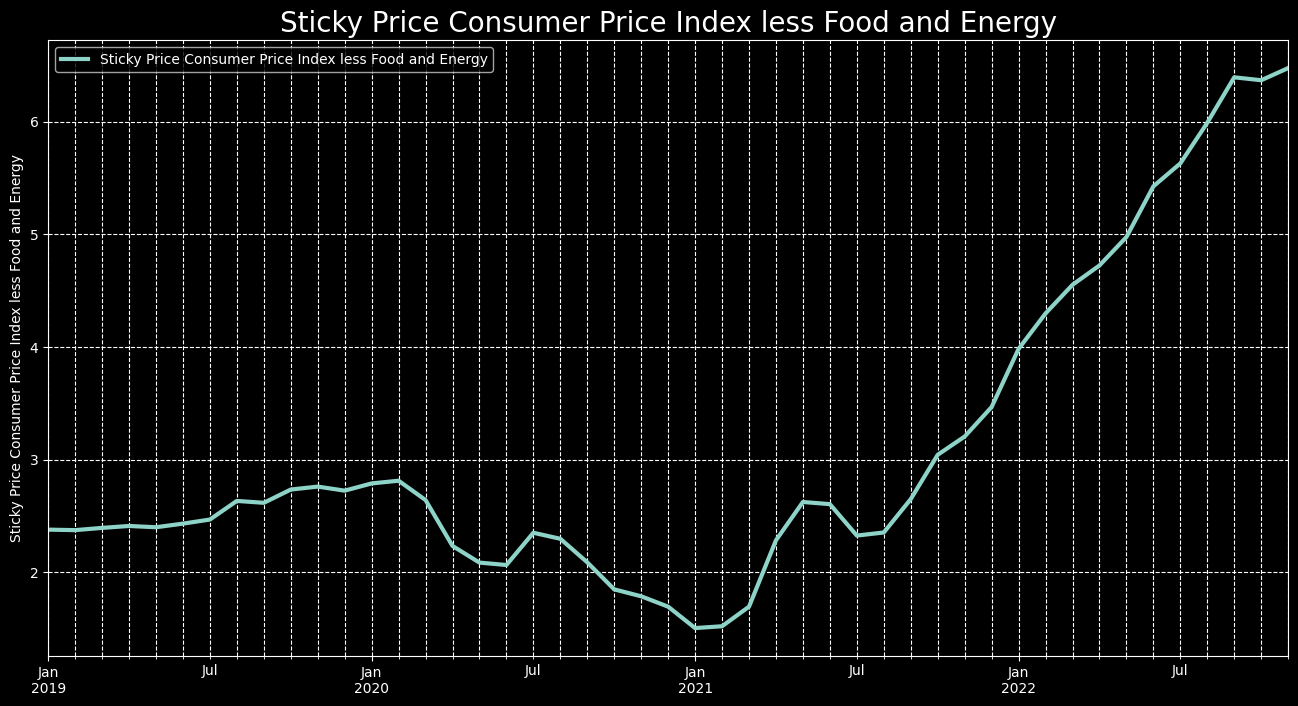

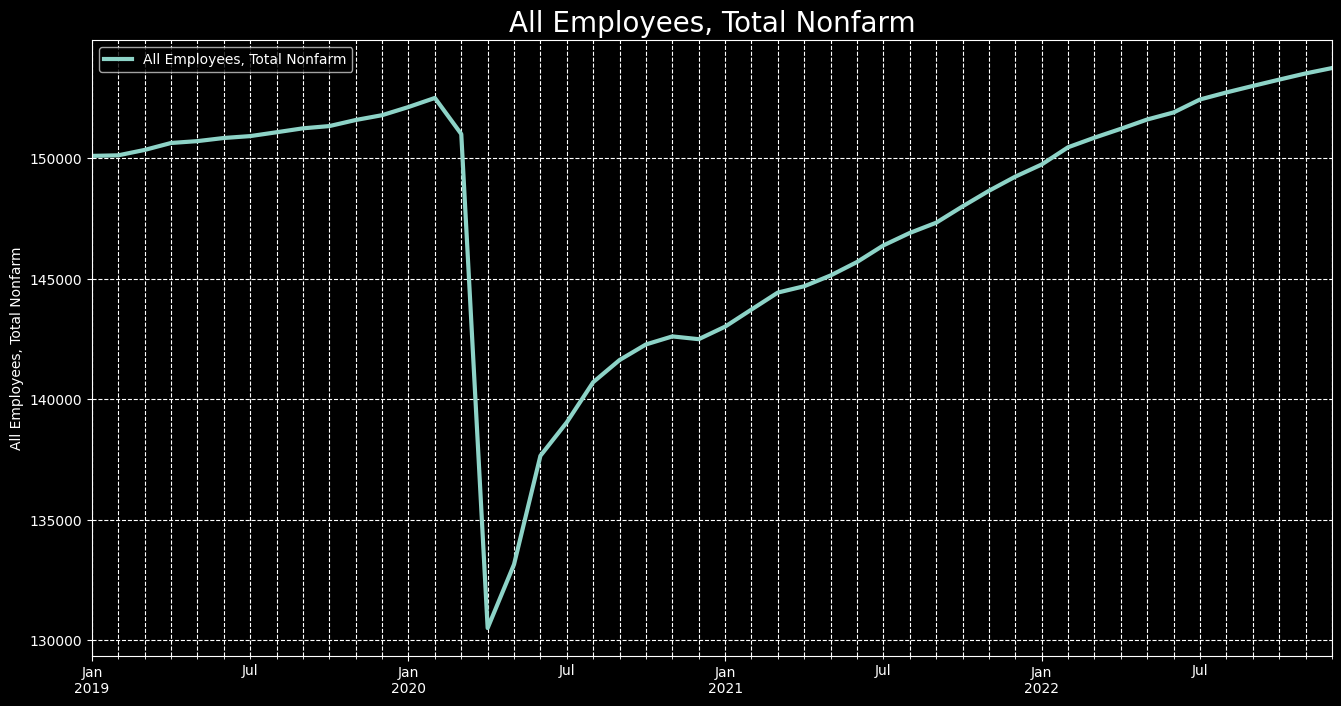

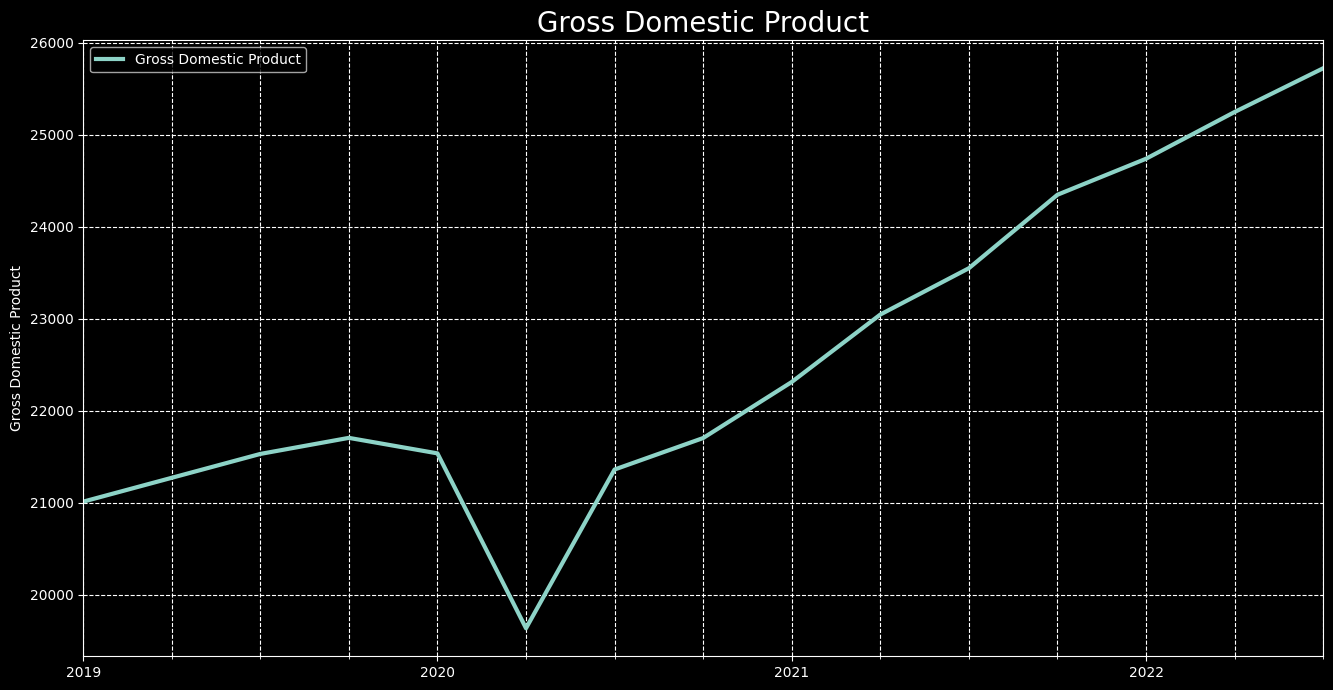

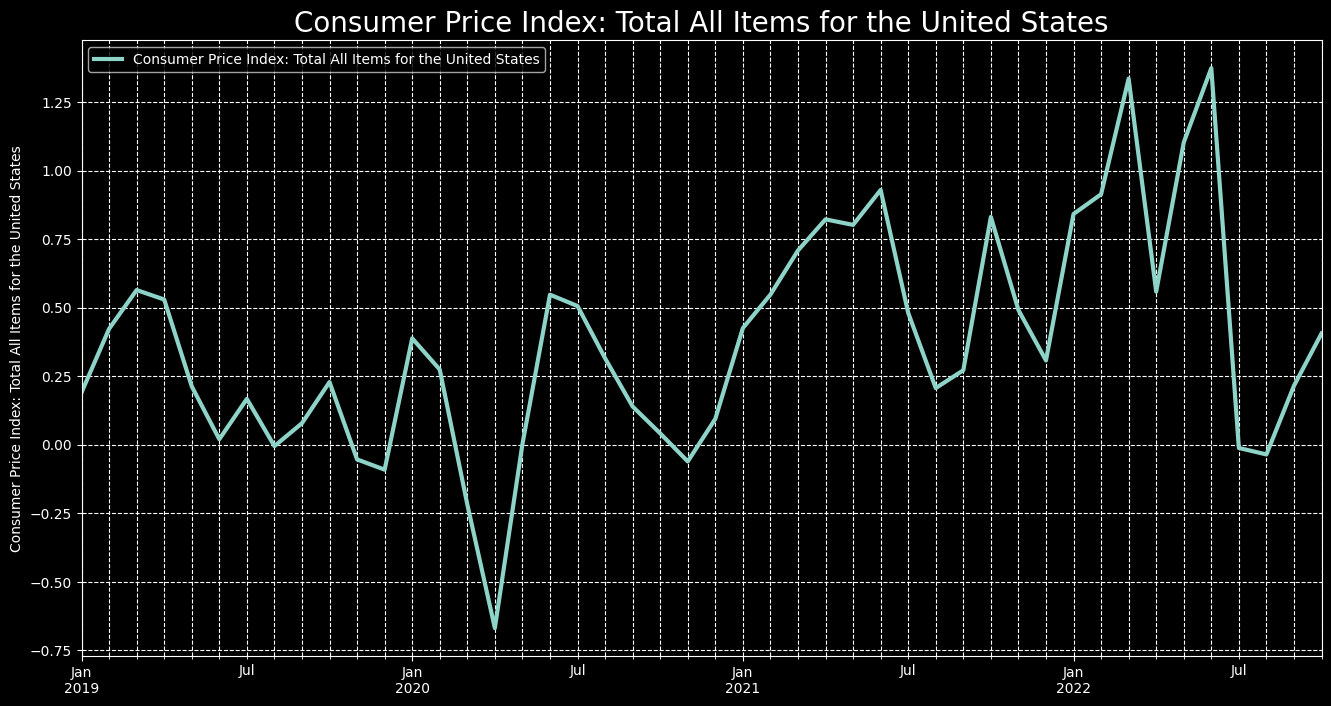

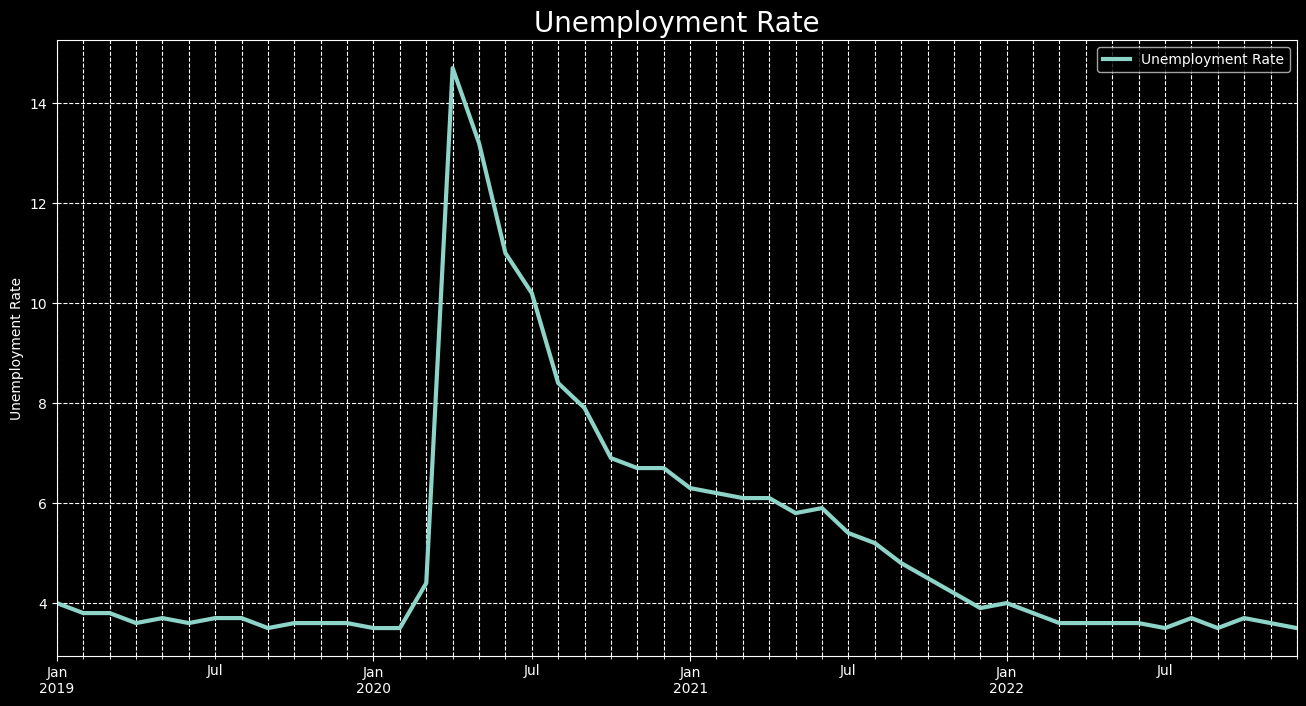

In [170]:
def update_econ_data(fred_sid_list=FEDIDLIST, fred_start_date=None,fed_end_date=None):

    global myapi_key,econ_data
    
    fred = fa.Fred(api_key= myapi_key )

    if(not fred_start_date):
        fred_start_date = "2019-01-01"

    if(not fed_end_date):
        fred_end_date = datetime.today()

    for id in fred_sid_list:
        info = fred.get_series_info(id)
        econ_data[id]= fred.get_series(id,fred_start_date,fred_end_date).to_frame()
        econ_data[id].columns = [info['title']]
        basic_dataframes_chart(econ_data[id],info['title'])


update_econ_data()

### Get Formated Datetime from Timestamp

In [130]:
def get_datetime_str_from_timestamp(tstimestamp,datatime_szformat='%Y-%m-%d'):
    """ 
    Convers a python Timestamp valiable into a string formatted per the provided
    szformat string
    format can be found at https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
    """
    
    return datetime.strftime(tstimestamp, datatime_szformat)

### Get Yahoo Finance Stock Price History

In [131]:
def get_yf_price_history(symbol, period=None,interval='1d',start_date=None,end_date=None):
    """ 
    Calls Yahoo Finance Ticker() function to retrieve stock historical prices 
    and returns a DataFrame
    """
    return yf.Ticker(symbol).history(interval=interval,period=period, start=start_date, end=end_date)

### Get Period Performace DataFrame 

In [132]:
def get_performance_df(df_list,period_start,period_end):
    """ 
    Takes a list of DataFrames of pre-calculated % Change price data
    and creates a Performance DataFrame over the period provided 
    """
    # Create a new dataframe
    perf_df = pd.DataFrame(columns=['Stocks','% Price Change']) 
    i = 0

    # Copy the last row of each stock dataframe into perf_df 
    for s in df_list.keys():
        perf_df.loc[i] = [s,np.round(df_list[s].iloc[-1],2)]
        i+=1

    # Set perf_df to the stocks column
    perf_df.set_index('Stocks',drop=True,inplace=True)
    
    return perf_df

### Download and Compare Changes in Stock Prices

In [133]:
def plot_price_change_comp(stock_list,start_date,end_date,interval):
    """
    Plot multiple stocks price %changes on one chart and returns
    a list of Dataframes for each stock symbob in stock_list 
    """
    
    main_df = {}
    for s in stock_list:
        main_df[s] = get_yf_price_history(symbol=s,interval=interval,start_date=start_date,end_date=end_date)['Close'].pct_change(periods=1).dropna().cumsum() * 100

    ax = ''
    for k in main_df.keys():
        if ax == '':
            ax = main_df[k].plot(figsize=(16,8),linewidth=3)    
        else:
            main_df[k].plot(ax=ax,linewidth=3)

    ax.set_title('Relative Perfomance: % Change of Stock Prices')
    ax.title.set_size(20)

    ax.set_xlabel("Time")
    ax.set_ylabel("% Price Change")

    ax.grid(True)
    ax.legend(main_df.keys())

    plt.show()
    return main_df


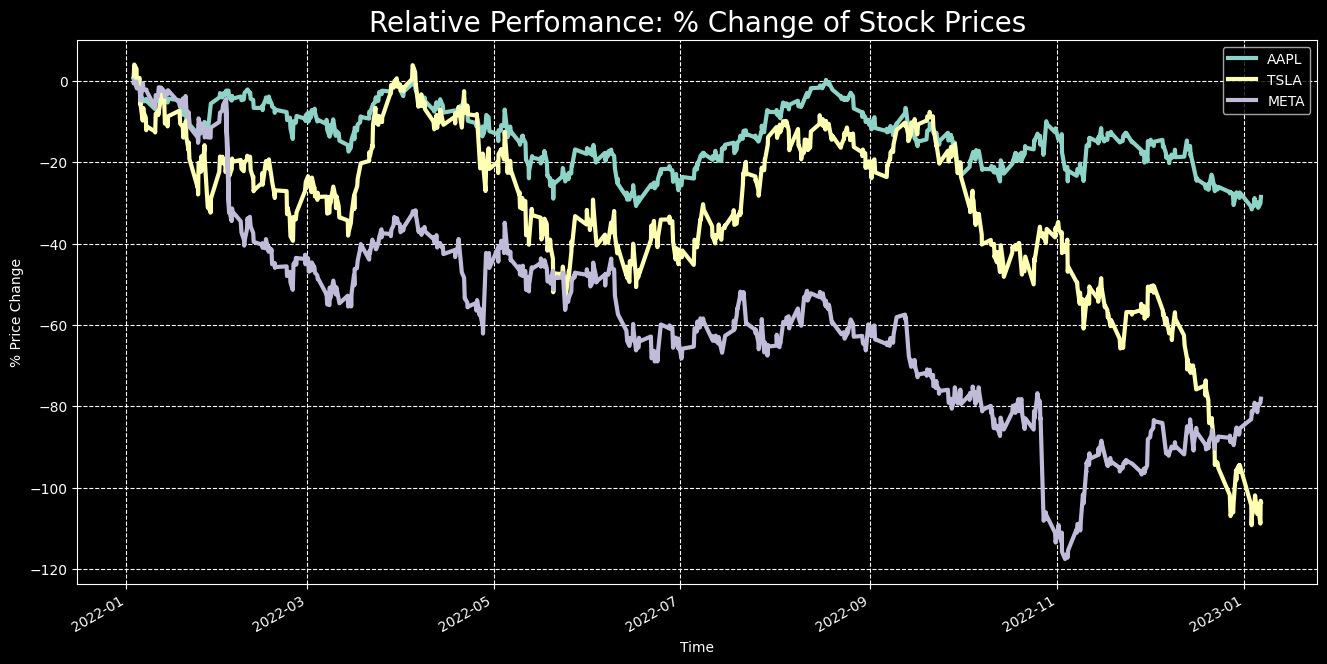

Stock Performaces from 2022-01-03 to 2023-01-06 13:33:29.620521


,% Price Change
Stocks,
AAPL,-28.50
TSLA,-103.54
META,-78.13


In [134]:

stock_list = ['AAPL','TSLA','META']
start_date = '2022-01-03'
end_date = datetime.now()
interval = '1h'

main_df = plot_price_change_comp(stock_list,start_date,end_date,interval)
perf_df = get_performance_df(df_list=main_df,period_start=start_date,period_end=end_date)
print('Stock Performaces from',start_date,'to',end_date)
display(perf_df)

In [137]:
def check_sma(price_history: object, SMA_lookback_in_dayes: int) -> float:
    
    # Calculate the stock's SMA
    sma = price_history.rolling(window=SMA_lookback_in_dayes).mean().dropna()
    
    # Calculate the change in the SMA over the 2 periods
    last_sma = np.NaN
    if len(sma) >= 2:
        last_sma = sma.iloc[-1]
        sma_change = last_sma - sma.iloc[-2]
    else:
        sma_change = np.NaN

    return last_sma, sma_change

symb = "AAPL"
start_date = '2017-01-01'
end_date = datetime.now()
interval = "1d"

testdf = yf.Ticker(symb).history(interval=interval, start=start_date, end=end_date)['Close']

sma_periods= [10,20,40]
date_format = "%A %m-%d-%Y %I:%M%p"
print(len(testdf))
#last_date_str = datetime.strftime(testdf.index[-1], date_format)
last_date_str = get_datetime_str_from_timestamp(testdf.index[-1],date_format)

print('Simple Moving Averages'+str(sma_periods)+' from',start_date,'to',end_date,'('+str(len(testdf))+' Trading Days)')
print(symb,"Price EOD on",last_date_str," = $",np.round(testdf.iloc[-1],2))
for i in sma_periods:
    sma, sma_change = check_sma(testdf, i)
    if( not (sma_change is np.NaN)):
        print("-- SMA("+str(i)+") =",str(np.round(sma,2))+'.',"The % Change in last",i,"days is",np.round(sma_change,2))

print("--")

1514
Simple Moving Averages[10, 20, 40] from 2017-01-01 to 2023-01-06 13:46:09.172313 (1514 Trading Days)
AAPL Price EOD on Friday 01-06-2023 12:00AM  = $ 128.61
-- SMA(10) = 128.48. The % Change in last 10 days is -0.68
-- SMA(20) = 133.69. The % Change in last 20 days is -0.62
-- SMA(40) = 140.3. The % Change in last 40 days is -0.27
--


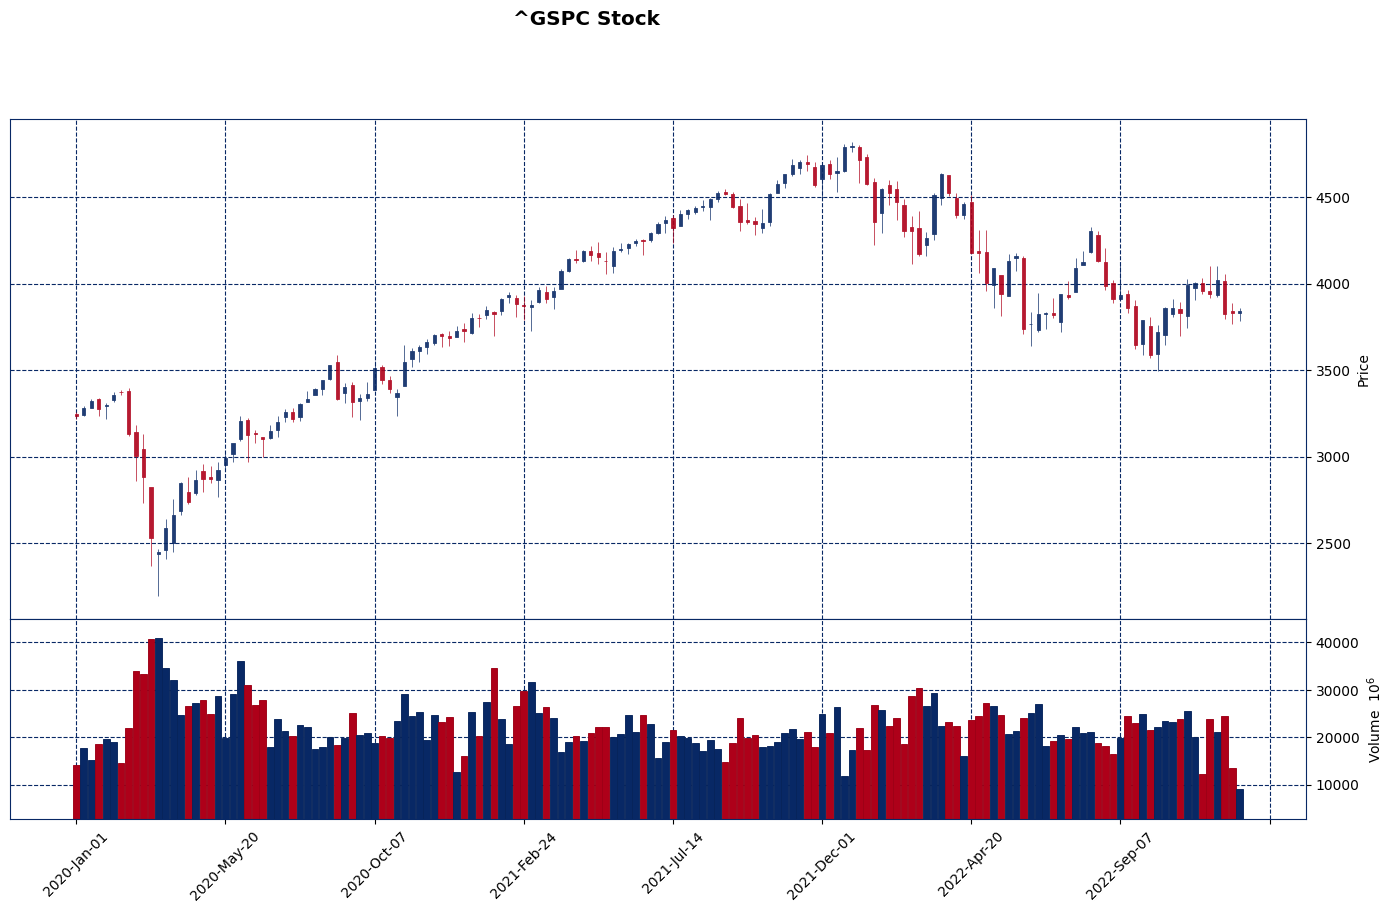

In [138]:
import matplotlib.dates as mpl_dates
import mplfinance as mpf

symbol='^GSPC'
interval = '1wk'

start_date = '2020-01-01'
end_date ='2022-12-31'

# Extracting Data for plotting
data = yf.Ticker(symbol).history(interval=interval,start=start_date, end=end_date)
data.index.name = 'Date'
kwargs={'warn_too_much_data':10000}
mpf.plot(data,figsize=(18,10),type='candle',volume=True,**kwargs,style='sas',title=symbol+" Stock")
